In [2]:
%matplotlib inline

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc

import os
import random
import pickle
import math

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint

print "using ordering:", K.image_dim_ordering()

using ordering: th


In [19]:
targetImageSize = 300.0  ### PARAMETER 1 - SETS SIZE OF SMALLEST IMAGE DIMENSION
targetRes = 32           ### PARAMETER 2 - CONTROLS THE SIZE OF THE TRAINING IMAGES
stride = 4               ### PARAMETER 3 - CONTROLS THE NUMBER OF SAMPLES PRODUCED

image_dim = 1

imageFolder = "box_data/images"

data = []

fileName = "002.jpg"
    
img = misc.imread("/".join([imageFolder, fileName]))

if image_dim == 1 and len(img.shape) > 2: 
    img = img[:,:,0]

fac = min(img.shape[0], img.shape[1]) / targetImageSize
img = misc.imresize(img, (int(img.shape[0]/fac), int(img.shape[1]/fac)), interp='nearest')
img = img / 255.0

xStep = int( math.floor( ( float(img.shape[0]) - targetRes ) / stride) )
yStep = int( math.floor( ( float(img.shape[1]) - targetRes ) / stride) )

for y in range(yStep):
    for x in range(xStep):
        image_crop = img[x * stride : (x * stride) + targetRes, y * stride : (y * stride) + targetRes]
        data.append(image_crop)
        
print "num samples:", len(data)

num samples: 4489


image dimensions: (300, 300)


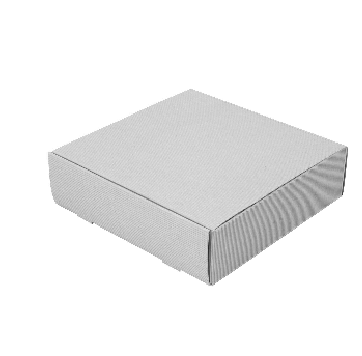

In [20]:
# preview image

print "image dimensions:", img.shape

imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 1,  interpolation='nearest')
plt.axis('off')
plt.show()

In [21]:
# specify input shape and number of classes for model

if K.image_dim_ordering() == 'th':
    input_shape = (1, targetRes, targetRes)
else:
    input_shape = (targetRes, targetRes, 1)

num_classes = 2

In [22]:
# RE-DEFINE MODEL - MAKE SURE THIS MATCHES EXACTLY WHAT YOU USED FOR TRAINING!

# model hyperparameters
batch_size = 32
nb_epoch = 20

# network architecture
patch_size_1 = 3
patch_size_2 = 3
patch_size_3 = 3
patch_size_4 = 3
patch_size_5 = 3

depth_1 = 64
depth_2 = 128
depth_3 = 128
depth_4 = 256
depth_5 = 256

pool_size = 2

num_hidden_1 = 512
num_hidden_2 = 1024

dropout = 0.25

In [23]:
# RE-DEFINE MODEL - MAKE SURE THIS MATCHES EXACTLY WHAT YOU USED FOR TRAINING!

model = Sequential()

model.add(Convolution2D(depth_1, patch_size_1, patch_size_1,
                        border_mode='same',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_2, patch_size_2, patch_size_2,
                        border_mode='same'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_3, patch_size_3, patch_size_3,
                        border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_4, patch_size_4, patch_size_4,
                        border_mode='same'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_5, patch_size_5, patch_size_5,
                        border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(num_hidden_1))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_hidden_2))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes))

model.add(Activation('softmax'))

In [24]:
# laod model from saved file

model.load_weights("-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [25]:
# build X dataset for prediction
# for memory management, we need to break up the dataset into batches, 
# run the predictions on each batch, and then recompile all predictions
# this will take some time!

max_batch_size = 10000
num_batches = int( math.ceil( len(data) / float(max_batch_size) ) )

print num_batches

pred = []

for batch in range(num_batches):
    batch_size = min( max_batch_size, len(data) - (batch * max_batch_size) )
    X = np.ndarray(( batch_size, targetRes, targetRes), dtype=np.float32)
    start_point = batch * max_batch_size
    
    for i, d in enumerate(data[ start_point : start_point + batch_size ]):
        X[i] = d
    
    if K.image_dim_ordering() == 'th':
        X = X.reshape(X.shape[0], 1, targetRes, targetRes)
    else:
        X = X.reshape(X.shape[0], targetRes, targetRes, 1)
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
    pred += np.argmax(model.predict(X), axis=1).tolist()

1


In [26]:
# create new image as numpy array, and build up image from predicted values
# here we are using the same nested loop that we used to generate samples 
# to reformat the list of predictions as a 2-d image

pred_img = np.ndarray(( xStep, yStep), dtype=np.int32)

count = 0

for y in range(yStep):
    for x in range(xStep):
        pred_img[x, y] = pred[count]
        count += 1

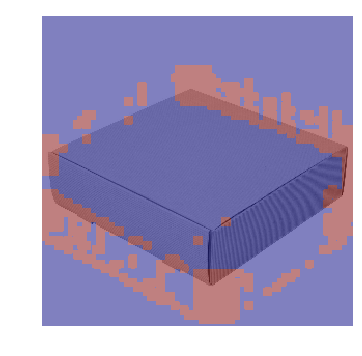

In [27]:
# plot image with predicted image overlayed

import scipy.misc

imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 1,  interpolation='nearest')

plt.hold(True)

pred = scipy.misc.imresize(pred_img, img.shape, interp='bilinear')
imshow(pred, vmin = 0, vmax = 1, alpha=.5, interpolation='nearest')

plt.axis('off')
plt.show()